In [1]:
from fastai.collab import *
from fastai.tabular import *
from pyunpack import Archive

## Epinions dataset

available from http://www.trustlet.org/datasets/

In [2]:
root = Path('/home/jupyter/fastai-d1/mendes/data/')
path=root/'epinions/'
#Archive(path/'ratings_data.txt.bz2').extractall(path)

In [3]:
# count=0
# with open(path/'ratings_data.txt') as url_f:
#     for line in url_f.readlines():
#         print(line)
#         count+=1
#         if count==10:
#             break

In [4]:
ratings = pd.read_csv(path/'ratings_data.txt', delimiter=' ',names=['user_id','item_id','rating_value'])
ratings.head()

,user_id,item_id,rating_value
0,1,100,4
1,1,101,5
2,1,102,3
3,1,10,3
4,1,103,5


In [5]:
data = CollabDataBunch.from_df(ratings, seed=42, valid_pct=0.1, item_name='item_id')

In [6]:
data.show_batch()

user_id,item_id,target
382,33976,5.0
4707,8553,5.0
2927,6128,4.0
723,3440,1.0
8791,45527,2.0


In [7]:
#the sigmoind function assymptotes the outputs so it will never be the extremes.
#that is why it is interesting to give some room for the limits
y_range = [0,5.5]

In [8]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
    
loss_func = RMSELoss()

#factors could be the lenght of the embedding size
#width of the emb matrix - related to latent factors
learn = collab_learner(data, n_factors=10, y_range=y_range, wd=1e-1, loss_func=loss_func)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


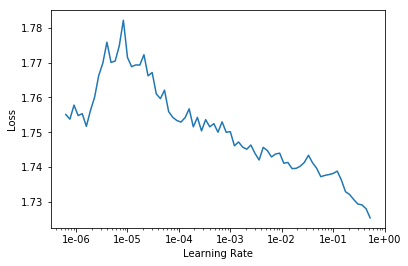

In [9]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [11]:
learn.fit_one_cycle(5, 5e-1)

epoch,train_loss,valid_loss,time
0,1.655192,1.652599,01:01
1,1.687303,1.670590,01:01


KeyboardInterrupt: 

In [ ]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [ ]:
learn.load('dotprod');

In [ ]:
learn.model

In [ ]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

### Movie bias

In [ ]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

In [ ]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [ ]:
item0 = lambda o:o[0]

In [ ]:
sorted(movie_ratings, key=item0)[:15]

In [ ]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

### Movie weights

In [ ]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

In [ ]:
movie_pca = movie_w.pca(3)
movie_pca.shape

In [ ]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

In [ ]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

In [ ]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()